Libraries

In [226]:
import zipfile, pathlib, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

I have chosen this because it has lesser anomolys to compute easy

In [227]:

csv_file = "realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv"


full time-series line plot

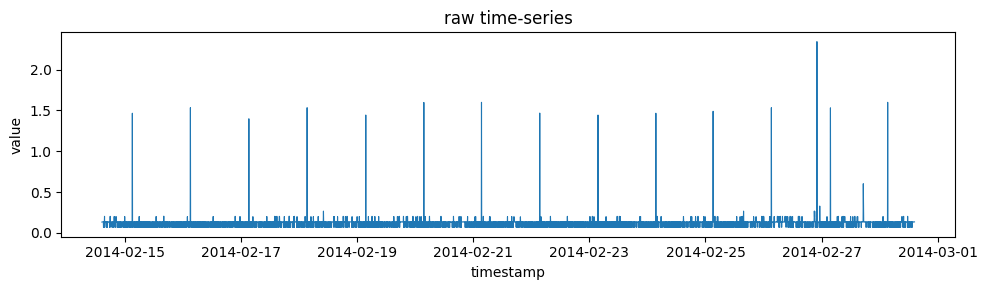

In [228]:
plt.figure(figsize=(10,3))
plt.plot(pd.to_datetime(df['timestamp']), df['value'], lw=.8)
plt.title("raw time-series")
plt.xlabel("timestamp"); plt.ylabel("value")
plt.tight_layout(); plt.show()

histogram of raw values

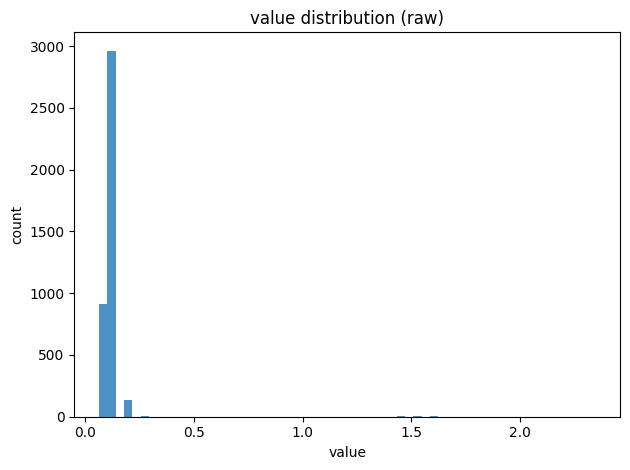

In [229]:
plt.figure()
plt.hist(df['value'], bins=60, alpha=.8)
plt.title("value distribution (raw)")
plt.xlabel("value"); plt.ylabel("count")
plt.tight_layout(); plt.show()

hyperparameter are kept small for speed

In [230]:
seq_len     = 48          
epochs      = 20
lr          = 1e-3
latent_dim  = 8
device      = "cuda" if torch.cuda.is_available() else "cpu"

Dataset utilities, mk_sequences turns the 1-d signal into sliding windows, ts_ds wraps those windows so dataloader can serve mini-batches.

In [231]:
def mk_sequences(arr, win):
    return np.stack([arr[i:i+win] for i in range(len(arr)-win)]).astype(np.float32)

class ts_ds(Dataset):
    def __init__(self, seqs): self.x = torch.from_numpy(seqs)
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i]

In [232]:
with zipfile.ZipFile(zip_path) as z:
    df = pd.read_csv(z.open(csv_file))
values = df["value"].values.astype(np.float32).reshape(-1, 1)
scaler = StandardScaler(); values = scaler.fit_transform(values).flatten()
seqs   = mk_sequences(values, seq_len)
data   = ts_ds(seqs)

In [233]:

n_train = int(len(data)*.7); n_val = int(len(data)*.15)
train_ds, val_ds, test_ds = random_split(data, [n_train, n_val, len(data)-n_train-n_val],
                                         generator=torch.Generator().manual_seed(42))
tl = DataLoader(train_ds, batch_size, True,  drop_last=True)
vl = DataLoader(val_ds,   batch_size, False, drop_last=True)
te = DataLoader(test_ds,  batch_size, False)

Autoencoder with optimizers
one-hidden-layer encoder

In [234]:
class ae(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(seq_len, 64), nn.ReLU(), nn.Linear(64, latent_dim))
        self.dec = nn.Sequential(nn.Linear(latent_dim, 64), nn.ReLU(), nn.Linear(64, seq_len))
    def forward(self, x): return self.dec(self.enc(x))

model = ae().to(device)
opt   = optim.Adam(model.parameters(), lr=lr)
crit  = nn.MSELoss()
def run(loader, train):
    model.train() if train else model.eval()
    loss_all = []
    for batch in loader:
        batch = batch.to(device)
        if train: opt.zero_grad()
        out = model(batch); loss = crit(out, batch)
        if train: loss.backward(); opt.step()
        loss_all.append(loss.item())
    return np.mean(loss_all)
for ep in range(1, epochs+1):
    tr, va = run(tl, True), run(vl, False)
    print(f"epoch {ep:02d} | train {tr:.4f} | val {va:.4f}")



epoch 01 | train 1.0348 | val 0.9210
epoch 02 | train 1.0067 | val 0.8982
epoch 03 | train 0.9776 | val 0.8673
epoch 04 | train 0.9074 | val 0.8296
epoch 05 | train 0.8766 | val 0.7881
epoch 06 | train 0.8207 | val 0.7514
epoch 07 | train 0.7725 | val 0.7205
epoch 08 | train 0.7290 | val 0.6892
epoch 09 | train 0.6806 | val 0.6599
epoch 10 | train 0.6454 | val 0.6300
epoch 11 | train 0.6140 | val 0.6003
epoch 12 | train 0.5770 | val 0.5737
epoch 13 | train 0.5434 | val 0.5524
epoch 14 | train 0.5101 | val 0.5315
epoch 15 | train 0.4899 | val 0.5117
epoch 16 | train 0.4724 | val 0.4940
epoch 17 | train 0.4415 | val 0.4812
epoch 18 | train 0.4296 | val 0.4657
epoch 19 | train 0.4136 | val 0.4550
epoch 20 | train 0.4021 | val 0.4411


grab per-window mse on train set, set threshold at μ + 3σ, flag any test window whose error crosses it.

In [235]:
def rec_err(loader):
    model.eval(); errs = []
    with torch.no_grad():
        for b in loader:
            b = b.to(device)
            errs.extend(((model(b)-b)**2).mean(dim=1).cpu().numpy())
    return np.array(errs)

train_err = rec_err(tl)
thr       = train_err.mean() + 3*train_err.std()
test_err  = rec_err(te)
y_pred    = (test_err > thr).astype(int)   
y_true    = np.zeros_like(y_pred)          

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred,
                                                   average="binary", zero_division=0)
print(f"\naccuracy {acc:.3f}  precision {prec:.3f}  recall {rec:.3f}  f1 {f1:.3f}")




accuracy 0.965  precision 0.000  recall 0.000  f1 0.000


compute accuracy, precision, recall, f1—even though labels are all zero for this csv, we still print.

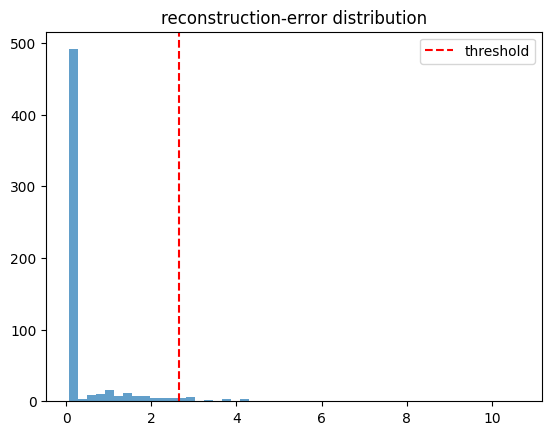

saved → ae_nab.pt


In [236]:
plt.hist(test_err, bins=50, alpha=.7)
plt.axvline(thr, color="r", ls="--", label="threshold")
plt.title("reconstruction-error distribution")
plt.legend(); plt.show()
torch.save(model.state_dict(), "ae_nab.pt")
print("saved → ae_nab.pt")

accuracy 0.965 looks shiny, but it’s inflated by class imbalance: the model simply said no anomaly everywhere. because we never predicted a 1, precision recall f1 all read 0.000.

train and val loss march down smoothly, halving by epoch 10 and tapering off after 15 epochs. that shows the autoencoder really does learn a tighter reconstruction without obvious overfit.